In [33]:
# pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git 

In [34]:
import numpy as np 
import matplotlib.pyplot as plt 
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD
from itertools import product
from qiskit.quantum_info import Statevector 

Los algoritmos variacionales cuánticos (VQA) son una clase prometedora de algoritmos híbridos cuántico-clásicos que utilizan un circuito cuántico parametrizado y un optimizador clásico para resolver problemas complejos, como encontrar mínimos energéticos en química cuántica o realizar aprendizaje automático. A pesar de su potencial aún existen desafios por superar para escalar estos algoritmos, siendo uno de los más criticos los __Barren Plateaus (BP)__.

El problema de BP surge cuando el landscape de la función de costo que se optimiza es extremadamente plano en una región amplia del espacio de parámetros. Esto implica que el gradiente de la función de costo es casi __nulo__ en esas regiones, dificultando significativamente la capacidad del optimizador clásico para encontrar direcciones de mejora. En tales casos, el entrenamiento del algoritmo se vuelve ineficiente, ya que requiere un número __exponencial__ de evaluaciones del gradiente para escapar de estas mesetas y aproximarse al óptimo. La presencia de BP está vinculada a varios factores, incluyendo la profundidad del circuito cuántico, la naturaleza del Hamiltoniano, y la inicialización de los parámetros. Entender y mitigar los barren plateaus es un área activa de investigación, con enfoques que incluyen diseños de circuitos específicos, estrategias de inicialización y métodos de optimización alternativos. En este desafio veremos como mitigar BP en un autoencoder cuántico.

Consideremos un autoencoder cuántico, es decir, un sistema bipartico $AB$ compuesto de $n_A$ y $n_B$ qubits, respectivamente, y un circuito variacional cuántico $V(\theta)$ que comprime un estado input $|\psi\rangle$. La función de costo a minimizar es
$$ C_G = 1 - \langle \psi |\left(I_A\otimes|0\cdots0\rangle\langle0\cdots0|_B\right) |\psi \rangle. $$
Esta función de costo puede reescribir como
$$C_G = \langle \psi | H_G | \psi \rangle, $$
donde $H_G$ es el siguiente Hamiltoniano.
$$ H_G = I_{AB} - I_A\otimes|0\cdots0\rangle\langle0\cdots0|_B. $$
Este Hamiltonian sufre de BP ya que es global, es decir, tiene componentes que actúan no trivialmente sobre un grán número de qubits []. Especificamente, el término $|0\cdots0\rangle\langle0\cdots0|_B$, el cual actúa sobre $n_B$ qubits. Este problema se puede solucionar cambiando el Hamiltoniano $H_G$ por una versión "local" $H_L$ que actúa sobre pocos qubits, dado por
$$ H_L = I_{AB} - \frac{1}{n_B}\sum_{j=1}^{n_B} I_A\otimes |0\rangle\langle0|_j\otimes I_{\bar{j}},$$
donde $|0\rangle\langle0|_j$ solo actúa sobre el qubit $j$ e $I_{\bar{j}}$ es la identidad en todos los qubits de B excepto en el qubit $j$. Se ha demostrado que este tipo de Hamiltonianos no exhibe barren plateaus para circuitos parametricos de profundidad $\mathcal{O}(\log(n))$. Sea
$$C_L = \langle \psi | H_L | \psi \rangle, $$
la nueva función objetivo con el Hamiltoniano local. Entonces, tenemos que
$$ C_L \leq C_G \leq n_B C_L,$$
es decir, la función local acota por abajo y por arriba la función global, de modo que tienen el mismo optimo y minimizar una tambien minimiza la otra. 

__Desafio:__ Considere $n_A=1$ y $n_B=8$. Consideremos que queremos comprimir el siguiente estado mixto
$$ \rho = \frac{1}{2}|\psi_1\rangle\langle\psi_1| +\frac{1}{2}|\psi_2\rangle\langle\psi_2|, $$
donde 
$$|\psi_1\rangle=|0\cdots000\rangle_B |0\rangle_A,$$
$$|\psi_2\rangle=|0\cdots011\rangle_B |1\rangle_A.$$
Construya un circuito que implemente este estado mixto. Para esto es necesario incluir un qubit auxiliar.

14


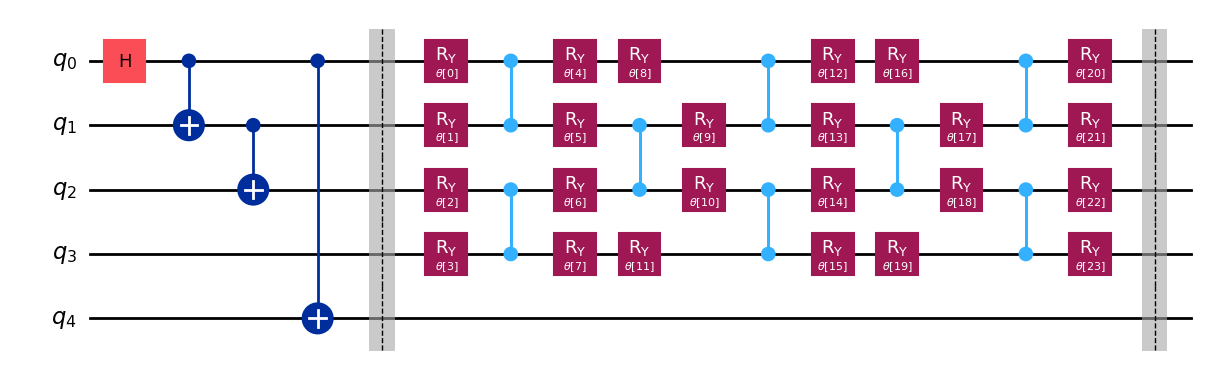

In [35]:
num_qubits_A = 1
num_qubits_B = 3
num_qubits = num_qubits_A + num_qubits_B 

qc_dato = QuantumCircuit(num_qubits+1)

qc_dato.h(0)
qc_dato.cx(0,1)
qc_dato.cx(1,2)
qc_dato.cx(0,num_qubits)

qc_dato.barrier() 

num_layers = 5
theta = ParameterVector(r'$\theta$',(num_layers+1)*num_qubits)

for layer in range(num_layers):
    for j in range(num_qubits):
        qc_dato.ry( theta[num_qubits*layer+j], j )
    if layer%2==0:
        for j in range(0,num_qubits-1,2):
            qc_dato.cz(j,j+1)
    else:
        for j in range(1,num_qubits-1,2):
            qc_dato.cz(j,j+1)
    # for j in range(0,num_qubits-1,2):
    #         qc_dato.cx(j,j+1)
    # for j in range(1,num_qubits-1,2):
    #         qc_dato.cx(j,j+1)
for j in range(num_qubits):
    qc_dato.ry( theta[num_layers*num_qubits+j], j )


qc_dato.barrier()

print( qc_dato.depth() )

qc_dato.draw('mpl')

En la siguiente celda se implementa el autoencoder variacional. A diferencia del taller, acá construimos el Hamiltoniano $H_G$ y evaluamos la fidelidad con la función ``Estimator``. Independiente del circuito que implementó en la celda anterior, podrá ver que la función objetivo no se minimiza, o en otras palabras, el circuito variacional no es entrenado. Esto se debe a que el Hamiltoniano $H_G$ es global y a que estamos usando un número de shots bajo. El BP puede eliminarse simplementa aumentando el número de shots hasta un valor suficientemente alto. Sin embargo, a pesar de que podemos hacer esto acá, en aplicaciones prácticas con más de 25 qubit el número de shots para evitar el BP es tan alto que no posible ejecutarlo. En este caso ponemos un número bajo de shots para inducir el BP en un número bajo de qubits y así evitar tiempos de simulación largos. 

In [36]:
shots = 100
np.random.seed(0)
params_init = np.pi*np.random.rand(qc_dato.num_parameters)
# params_init = np.zeros(qc_dato.num_parameters) 
shots

100

SparsePauliOp(['IIIII', 'IIIZI', 'IIZII', 'IIZZI', 'IZIII', 'IZIZI', 'IZZII', 'IZZZI'],
              coeffs=[0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
 0.125+0.j, 0.125+0.j])


C:\Users\lucia\AppData\Local\Temp\ipykernel_24356\847321058.py:22: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  fs_global = Global_QAE(params_init)
C:\Users\lucia\AppData\Local\Temp\ipykernel_24356\847321058.py:22: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  fs_global = Global_QAE(params_init)


{   'fun': np.float64(0.42999999999999994),
    'jac': None,
    'nfev': 194,
    'nit': None,
    'njev': None,
    'x': array([ 2.64824798,  2.507127  ,  1.26545746,  2.00091133,  0.67578734,
        2.10205776,  2.31835908,  2.90668009,  2.81930021,  2.58016292,
        3.45359027,  1.3608697 ,  3.291052  ,  2.72111058, -0.00433672,
        0.28955221,  0.12095338,  2.60179034,  1.86561708,  2.11582444,
        3.01263705,  2.04660736,  1.43554533,  2.24248712])}


(-0.05, 1.05)

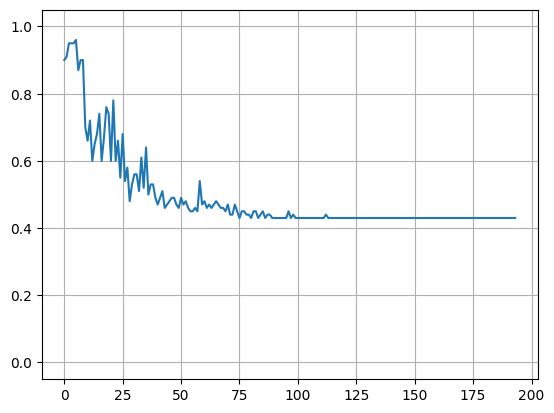

In [41]:
def Global_QAE(x0=np.zeros(qc_dato.num_parameters), rhobeg=1):
    ops = [ 'I'+''.join(a)+(num_qubits_A*'I') for a in product(['I','Z'], repeat=num_qubits_B ) ]
    coef = np.ones(len(ops))/2**num_qubits_B 
    H_global = SparsePauliOp( ops, coef ).simplify()
    print( H_global )
    backend = Estimator(run_options={'seed':0})

    def fun_global( params ):
        job   = backend.run( qc_dato, H_global, params, shots=shots )
        probs = job.result().values[0]
        return 1-probs 

    fs = []
    def callback(x):
        fs.append(fun_global(x))

    optimizer = COBYLA( callback=callback, rhobeg=rhobeg )
    results_global   = optimizer.minimize( fun_global, x0 )
    print( results_global )
    return fs

fs_global = Global_QAE(params_init)

plt.plot( fs_global ) 
plt.grid()
plt.ylim(-0.05,1.05)

__Desafio:__ Complete la siguiente función que implementa el autoencoder cuántico con Hamiltoniano local $H_L$. 

In [38]:
def local_hamiltonian():
    ops = []
    for j in range(num_qubits_B):
        x = np.zeros(num_qubits+1)
        z = np.zeros(num_qubits+1)
        ops.append( Pauli( (z, x) ) )
        z[num_qubits_A+j] = 1 
        ops.append( Pauli( (z, x) ) )

    coef = np.ones(len(ops))/(2*num_qubits_B)
    H_local = SparsePauliOp( ops, coef ).simplify()
    
    return H_local 

SparsePauliOp(['IIIII', 'IIIZI', 'IIZII', 'IZIII'],
              coeffs=[0.5       +0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j])


C:\Users\lucia\AppData\Local\Temp\ipykernel_24356\2834996273.py:31: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  x_local, fs_local = Local_QAE(params_init)
C:\Users\lucia\AppData\Local\Temp\ipykernel_24356\2834996273.py:31: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  x_local, fs_local = Local_QAE(params_init)


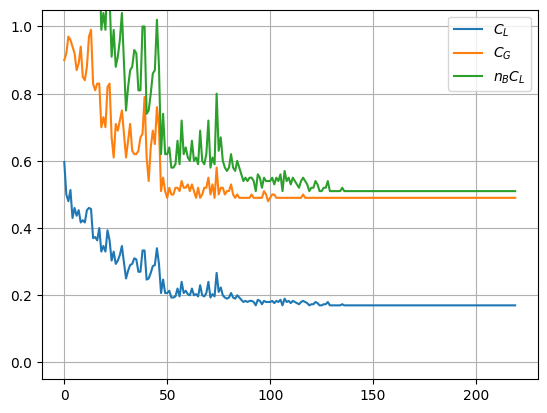

In [39]:
def Local_QAE(x0=np.zeros(qc_dato.num_parameters), rhobeg=1 ):

    ops = [ 'I'+''.join(a)+(num_qubits_A*'I') for a in product(['I','Z'], repeat=num_qubits_B ) ]
    coef = np.ones(len(ops))/(2**num_qubits_B) 
    H_global = SparsePauliOp( ops, coef ).simplify()

    H_local = local_hamiltonian()
    print( H_local )

    backend = Estimator(run_options={'seed':0})

    def fun_global( params ):
        job   = backend.run( qc_dato, H_global, params, shots=shots )
        probs = job.result().values[0]
        return 1-probs 

    def fun_local( params ):
        job   = backend.run( qc_dato, H_local, params, shots=shots )
        probs = job.result().values[0]
        return 1-probs 

    fs = []
    def callback(x): 
        fs.append( [fun_local(x),fun_global(x), num_qubits_B*fun_local(x)] )

    optimizer = COBYLA( callback=callback, rhobeg=rhobeg )
    results_local   = optimizer.minimize( fun_local, x0 )

    return results_local.x, fs 

x_local, fs_local = Local_QAE(params_init)

plt.plot( fs_local ) 
plt.grid()
plt.ylim(-0.05,1.05)
plt.legend([r'$C_L$', r'$C_G$', r'$n_BC_L$']) 

En la figura anterior podemos ver que con el Hamiltoniano local permite entrenar el circuito. Además, se observa como la función objetivo global esta acotado tanto por abajo como por arriba por la función objetivo local, y que se minimizan simultaneamente. Una obsevación interesante es que podemos agregar una segunda etapa donde utilizamos el resultado de la optimización local como condición inicial para entrenar el circuito con la función global. Esto puede mejorar el entrenamiento porque gracias a la optimización local ya se salió del landscape plano de la función objetivo. 

C:\Users\lucia\AppData\Local\Temp\ipykernel_24356\3423807216.py:1: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  fs_global = Global_QAE(x_local, rhobeg=0.25)
C:\Users\lucia\AppData\Local\Temp\ipykernel_24356\3423807216.py:1: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  fs_global = Global_QAE(x_local, rhobeg=0.25)


{   'fun': np.float64(0.47),
    'jac': None,
    'nfev': 140,
    'nit': None,
    'njev': None,
    'x': array([ 2.0855197 ,  3.29102745,  2.49471386,  1.93918004,  1.09237299,
        2.60556478,  1.25059671,  2.72629801,  4.10638013,  1.28859299,
        2.95388381,  1.66402221,  1.75220887,  2.76141166,  1.58610534,
       -0.30255474,  1.07087918,  2.44997824,  4.37875442,  2.82039956,
        3.07442019,  2.07828601,  1.63489202,  3.35827371])}


(-0.05, 1.05)

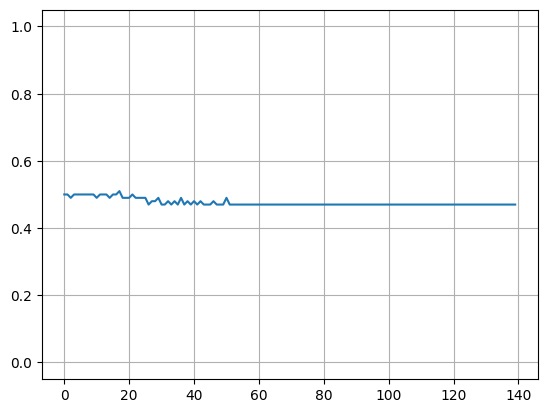

In [40]:
fs_global = Global_QAE(x_local, rhobeg=0.25)

plt.plot( fs_global ) 
plt.grid()
plt.ylim(-0.05,1.05)
